In [2]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import re
import glob
from collections import Counter, defaultdict
from PIL import Image
import math

### Followers vs Following overlap

In [6]:
with open("instagram_data/connections/followers_and_following/followers_1.json") as f:
    followers_data = json.load(f)

followers = [entry["string_list_data"][0]["href"].split("/")[-1] for entry in followers_data]
followers_df = pd.DataFrame(followers, columns=["username"])

In [11]:
with open("instagram_data/connections/followers_and_following/following.json") as f:
    following_data = json.load(f)

following = [entry["string_list_data"][0]["href"].split("/")[-1] for entry in following_data["relationships_following"]]
following_df = pd.DataFrame(following, columns=["username"])

In [12]:
mutuals = set(followers_df.username) & set(following_df.username)
len(mutuals)

277

### Story posting frequency over time

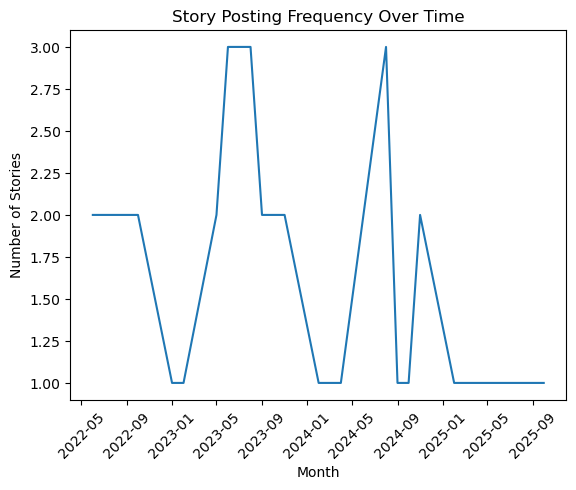

In [91]:
base_path = "instagram_data/media/stories"

story_counts = []

for folder in os.listdir(base_path):
    folder_path = os.path.join(base_path, folder)
    
    if os.path.isdir(folder_path) and re.fullmatch(r"\d{6}", folder):
        num_stories = len(os.listdir(folder_path))
        story_counts.append((folder, num_stories))

stories_df = pd.DataFrame(story_counts, columns=["month", "story_count"])

stories_df["month"] = pd.to_datetime(stories_df["month"], format="%Y%m")
stories_df = stories_df.sort_values("month")

plt.figure()
plt.plot(stories_df["month"], stories_df["story_count"])
plt.title("Story Posting Frequency Over Time")
plt.xlabel("Month")
plt.ylabel("Number of Stories")
plt.xticks(rotation=45)
plt.show()

### Who I message the most

In [92]:
inbox_path = "instagram_data/your_instagram_activity/messages/inbox"

rows = []

for convo_dir in os.listdir(inbox_path):
    convo_path = os.path.join(inbox_path, convo_dir)
    if not os.path.isdir(convo_path):
        continue

    # Grab all message_*.json files in that conversation folder
    msg_files = sorted(glob.glob(os.path.join(convo_path, "message_*.json")))
    if not msg_files:
        continue

    participants = None
    total_msgs = 0

    for mf in msg_files:
        with open(mf, "r", encoding="utf-8") as f:
            data = json.load(f)

        # participants should be the same across files; take it from the first one
        if participants is None:
            participants = [p.get("name") for p in data.get("participants", [])]

        total_msgs += len(data.get("messages", []))

    # Make a readable conversation label:
    # if it's 1-on-1, show the other person; if group, show a joined name string
    if participants:
        label = participants[0] if len(participants) == 1 else ", ".join(participants[:3]) + ("..." if len(participants) > 3 else "")
    else:
        label = convo_dir  # fallback

    rows.append({"conversation": label, "message_count": total_msgs, "num_files": len(msg_files)})

messages_df = pd.DataFrame(rows).sort_values("message_count", ascending=False)

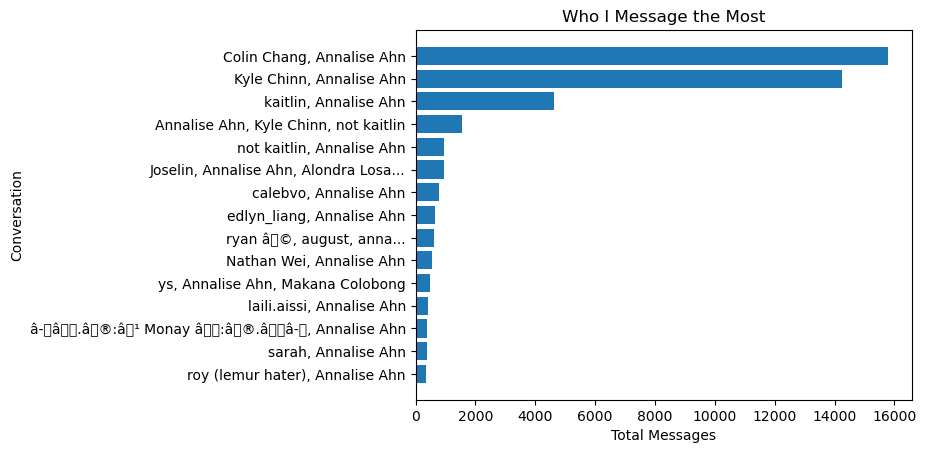

In [95]:
top = messages_df.head(15).sort_values("message_count")

plt.figure()
plt.barh(top["conversation"], top["message_count"])
plt.title("Who I Message the Most")
plt.xlabel("Total Messages")
plt.ylabel("Conversation")
plt.show()

### Instagram Likes by hour of day

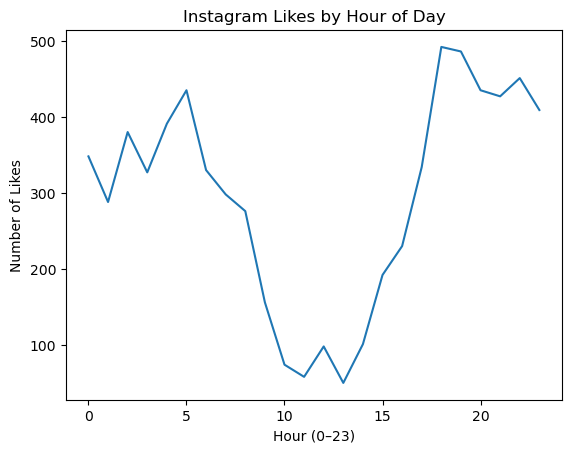

In [34]:
with open("instagram_data/your_instagram_activity/likes/liked_posts.json") as f:
    likes_data = json.load(f)

timestamps = []

for entry in likes_data["likes_media_likes"]:
    sld = entry.get("string_list_data", [])
    if len(sld) > 0 and "timestamp" in sld[0]:
        timestamps.append(datetime.fromtimestamp(sld[0]["timestamp"]))

likes_df = pd.DataFrame(timestamps, columns=["datetime"])

likes_df["hour"] = likes_df["datetime"].dt.hour

hour_counts = likes_df["hour"].value_counts().sort_index()

plt.figure()
plt.plot(hour_counts.index, hour_counts.values)
plt.title("Instagram Likes by Hour of Day")
plt.xlabel("Hour (0–23)")
plt.ylabel("Number of Likes")
plt.show()

### Recommended topics

In [98]:
with open("instagram_data/preferences/your_topics/recommended_topics.json") as f:
    topics_data = json.load(f)

topics = []

for entry in topics_data["topics_your_topics"]:
    topic_name = entry["string_map_data"]["Name"]["value"]
    topics.append(topic_name)

topics_df = pd.DataFrame(topics, columns=["topic"])
pd.set_option("display.max_rows", None)
topics_df
pd.reset_option("display.max_rows")

### Top accounts whose stories I've liked

In [96]:
with open("instagram_data/your_instagram_activity/story_interactions/story_likes.json") as f:
    story_likes_data = json.load(f)

accounts = []

for entry in story_likes_data["story_activities_story_likes"]:
    username = entry.get("title")
    if username:
        accounts.append(username)

account_counts = Counter(accounts)

story_likes_df = pd.DataFrame(
    account_counts.items(),
    columns=["account", "story_likes"]
).sort_values("story_likes", ascending=False)

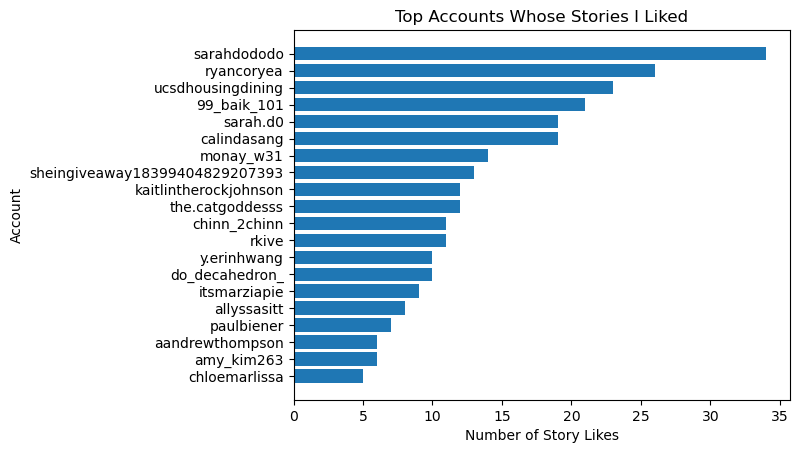

In [97]:
top = story_likes_df.head(20).sort_values("story_likes")

plt.figure()
plt.barh(top["account"], top["story_likes"])
plt.title("Top Accounts Whose Stories I Liked")
plt.xlabel("Number of Story Likes")
plt.ylabel("Account")
plt.show()

### Most sent images

In [4]:
# ---------- dHash implementation ----------
def dhash(image: Image.Image, hash_size: int = 8) -> int:
    """
    Returns a 64-bit (for hash_size=8) perceptual hash as an int.
    """
    img = image.convert("L").resize((hash_size + 1, hash_size), Image.Resampling.LANCZOS)
    pixels = list(img.getdata())
    # Compare adjacent pixels in each row
    result = 0
    bit = 1
    for row in range(hash_size):
        row_start = row * (hash_size + 1)
        for col in range(hash_size):
            left = pixels[row_start + col]
            right = pixels[row_start + col + 1]
            if left > right:
                result |= bit
            bit <<= 1
    return result

def hamming_distance(a: int, b: int) -> int:
    return (a ^ b).bit_count()

# ---------- Extract image URIs from message json ----------
def extract_photo_uris(message_obj: dict):
    uris = []
    photos = message_obj.get("photos", [])
    for p in photos:
        uri = p.get("uri")
        if uri:
            uris.append(uri)
    return uris

# ---------- Main ----------
# Root to your export folder (the one that contains "your_instagram_activity")
EXPORT_ROOT = "instagram_data"

inbox_path = os.path.join(EXPORT_ROOT, "your_instagram_activity", "messages", "inbox")

# If you only want images YOU sent, set this to your exact sender_name string from the JSON.
ONLY_SENT_BY = "Annalise Ahn"  # e.g. "Annalise Ahn"

# Gather all image filepaths referenced in messages
image_paths = []

for convo_dir in os.listdir(inbox_path):
    convo_path = os.path.join(inbox_path, convo_dir)
    if not os.path.isdir(convo_path):
        continue

    for mf in sorted(glob.glob(os.path.join(convo_path, "message_*.json"))):
        with open(mf, "r", encoding="utf-8") as f:
            data = json.load(f)

        for msg in data.get("messages", []):
            if ONLY_SENT_BY is not None and msg.get("sender_name") != ONLY_SENT_BY:
                continue

            for uri in extract_photo_uris(msg):
                # In Instagram exports, uri is typically relative to EXPORT_ROOT
                abs_path = os.path.join(EXPORT_ROOT, uri)
                if os.path.exists(abs_path):
                    image_paths.append(abs_path)

print("Referenced images found on disk:", len(image_paths))

# Compute hashes
hash_to_files = defaultdict(list)
bad_files = 0

for path in image_paths:
    try:
        with Image.open(path) as im:
            h = dhash(im, hash_size=8)
        hash_to_files[h].append(path)
    except Exception:
        bad_files += 1

print("Unique hashes:", len(hash_to_files))
print("Unreadable images:", bad_files)

# ---------- Option B: near-identical grouping (Hamming distance <= threshold) ----------
# This merges hashes that are extremely close (cropped/edited slightly, recompressed, etc.)
threshold = 4  # 0 = exact hash match only; 4 is usually "very similar"
hashes = list(hash_to_files.keys())
used = set()
near_groups = []

for i, h in enumerate(hashes):
    if h in used:
        continue
    group_hashes = [h]
    used.add(h)

    for j in range(i + 1, len(hashes)):
        h2 = hashes[j]
        if h2 in used:
            continue
        if hamming_distance(h, h2) <= threshold:
            group_hashes.append(h2)
            used.add(h2)

    # collect files
    group_files = []
    for gh in group_hashes:
        group_files.extend(hash_to_files[gh])

    near_groups.append((group_hashes, group_files))

near_groups.sort(key=lambda x: len(x[1]), reverse=True)

print(f"\nTop near-duplicate groups (Hamming <= {threshold}):")
for group_hashes, files in near_groups[:10]:
    if len(files) > 1:
        print(len(files), "total occurrences across", len(group_hashes), "hashes")
        print("  example:", files[0])

Referenced images found on disk: 195
Unique hashes: 180
Unreadable images: 0

Top near-duplicate groups (Hamming <= 4):
2 total occurrences across 1 hashes
  example: instagram_data/your_instagram_activity/messages/inbox/obamna_815382897905552/photos/1823106001903660.jpg
2 total occurrences across 1 hashes
  example: instagram_data/your_instagram_activity/messages/inbox/kylechinn_1292449912290311/photos/867045455720299.jpg
2 total occurrences across 1 hashes
  example: instagram_data/your_instagram_activity/messages/inbox/kylechinn_1292449912290311/photos/879713841201944.jpg
2 total occurrences across 1 hashes
  example: instagram_data/your_instagram_activity/messages/inbox/kylechinn_1292449912290311/photos/1211578890901106.jpg
2 total occurrences across 1 hashes
  example: instagram_data/your_instagram_activity/messages/inbox/kylechinn_1292449912290311/photos/1225478352777575.jpg
2 total occurrences across 1 hashes
  example: instagram_data/your_instagram_activity/messages/inbox/kylec

Total times sent: 2
Unique visual variations (hashes): 1
Images shown: 1

Group 1
Total sends: 2
Visual variations: 1


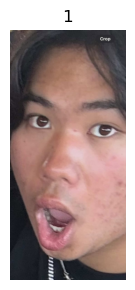


Group 2
Total sends: 2
Visual variations: 1


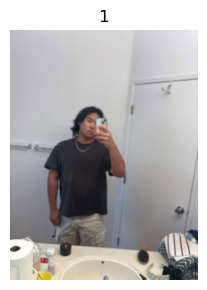


Group 3
Total sends: 2
Visual variations: 1


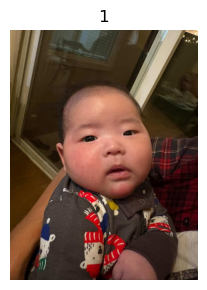


Group 4
Total sends: 2
Visual variations: 1


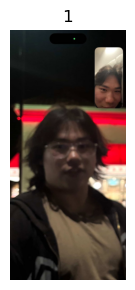


Group 5
Total sends: 2
Visual variations: 1


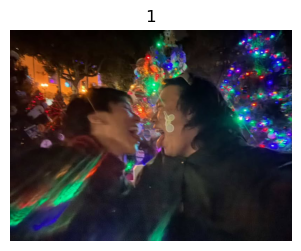


Group 6
Total sends: 2
Visual variations: 1


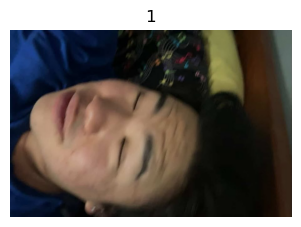


Group 7
Total sends: 2
Visual variations: 1


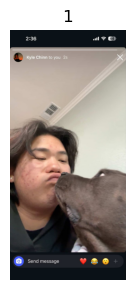


Group 8
Total sends: 2
Visual variations: 1


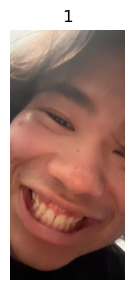


Group 9
Total sends: 2
Visual variations: 1


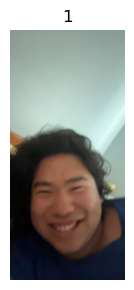


Group 10
Total sends: 2
Visual variations: 1


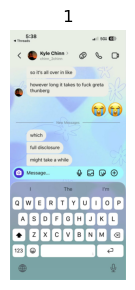


Group 11
Total sends: 2
Visual variations: 1


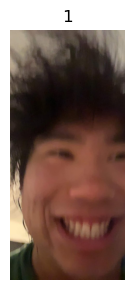


Group 12
Total sends: 2
Visual variations: 1


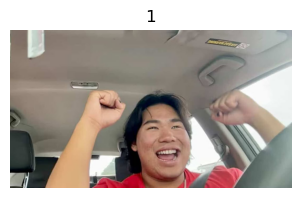


Group 13
Total sends: 2
Visual variations: 1


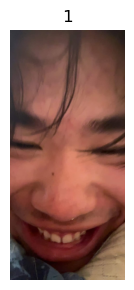


Group 14
Total sends: 2
Visual variations: 1


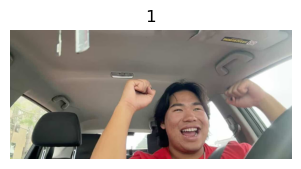


Group 15
Total sends: 2
Visual variations: 2


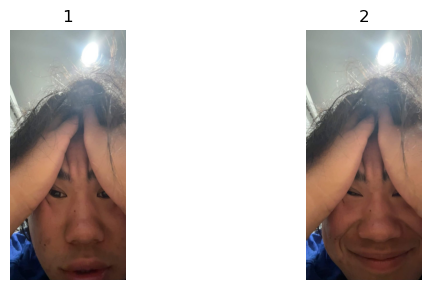


Group 16
Total sends: 2
Visual variations: 1


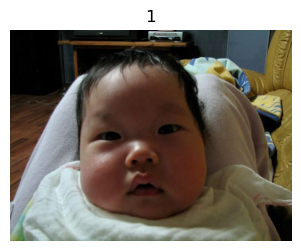


Group 17
Total sends: 1
Visual variations: 1


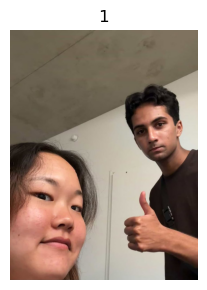


Group 18
Total sends: 1
Visual variations: 1


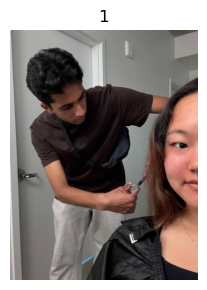


Group 19
Total sends: 1
Visual variations: 1


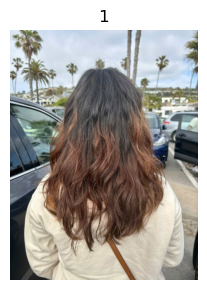


Group 20
Total sends: 1
Visual variations: 1


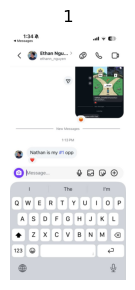

In [5]:
def show_image_group(image_paths, max_images=12):
    """
    Display images in a clean grid.
    """
    image_paths = image_paths[:max_images]
    n = len(image_paths)

    cols = 4
    rows = math.ceil(n / cols)

    plt.figure(figsize=(12, 3 * rows))

    for i, path in enumerate(image_paths):
        try:
            img = Image.open(path)
            plt.subplot(rows, cols, i + 1)
            plt.imshow(img)
            plt.axis("off")
            plt.title(f"{i+1}")
        except:
            continue

    plt.tight_layout()
    plt.show()

# Get the top near-duplicate group
group_hashes, group_files = near_groups[0]

# One representative image per hash
representatives = []
for h in group_hashes:
    representatives.append(hash_to_files[h][0])

print("Total times sent:", len(group_files))
print("Unique visual variations (hashes):", len(group_hashes))
print("Images shown:", len(representatives))

for i in range(20):
    group_hashes, group_files = near_groups[i]

    representatives = [hash_to_files[h][0] for h in group_hashes]

    print(f"\nGroup {i+1}")
    print("Total sends:", len(group_files))
    print("Visual variations:", len(group_hashes))

    show_image_group(representatives, max_images=12)